In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from tensorflow.keras.preprocessing import image
from PIL import Image
import io
from datetime import datetime
import tensorflow as tf
from tensorflow.keras import layers, models

In [2]:
# Pay attemtion to the path 
base_dir = '../real_vs_fake/real-vs-fake'
#|--project
#|-----TechLabs-DL-2024
#|----------model.ipynb
#|----------README.md
#|-----real-vs-fake
#|----------test
#|----------train
#|----------valid

train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

In [3]:
batch_size = 20
img_size = (150,150)
sample_count = 102041

train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    classes=['real', 'fake'],
    shuffle=True,
    subset=None,
    seed=42
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    classes=['real', 'fake'],
    shuffle=True,
    subset=None,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    classes=['real', 'fake'],
    shuffle=False
)

# train_generator.samples = 2 * sample_count  # causing errors in training
#train_generator.batch_size = batch_size

Found 102041 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [4]:
# Load the InceptionV3
base_model = tf.keras.applications.InceptionV3(
    weights='imagenet', 
    include_top=False,  # We don't need the top layer (fully connected layer)
    input_shape=(150, 150, 3)  # Input shape your images
)

In [5]:
for layer in base_model.layers:
    layer.trainable = False

In [6]:
# Add custom layers on top of the base model
model = models.Sequential([
    base_model,  # Add the base model as the first layer
    layers.GlobalAveragePooling2D(),  # Reduces dimensions without further convolutions
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [7]:
history = model.fit(
    train_generator,
    steps_per_epoch= train_generator.samples // batch_size,  # number of batches per epoch
    epochs=10,
    validation_data=valid_generator,
    validation_steps= valid_generator.samples // batch_size
)

Epoch 1/10


2024-09-04 23:22:41.795024: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-09-04 23:22:41.800459: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


5102/5102 [==============================] - ETA: 0s - loss: 0.6028 - accuracy: 0.6709

2024-09-04 23:49:05.379910: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


5102/5102 [==============================] - 1927s 377ms/step - loss: 0.6028 - accuracy: 0.6709 - val_loss: 0.5728 - val_accuracy: 0.7034
Epoch 2/10
5102/5102 [==============================] - 2086s 409ms/step - loss: 0.5616 - accuracy: 0.7034 - val_loss: 0.5599 - val_accuracy: 0.7347
Epoch 3/10
5102/5102 [==============================] - 2071s 406ms/step - loss: 0.5488 - accuracy: 0.7141 - val_loss: 0.5526 - val_accuracy: 0.7394
Epoch 4/10
5102/5102 [==============================] - 2066s 405ms/step - loss: 0.5406 - accuracy: 0.7191 - val_loss: 0.5464 - val_accuracy: 0.7488
Epoch 5/10
5102/5102 [==============================] - 2073s 406ms/step - loss: 0.5363 - accuracy: 0.7237 - val_loss: 0.5320 - val_accuracy: 0.7501
Epoch 6/10
5102/5102 [==============================] - 2068s 405ms/step - loss: 0.5324 - accuracy: 0.7277 - val_loss: 0.5120 - val_accuracy: 0.7501
Epoch 7/10
5102/5102 [==============================] - 2058s 403ms/step - loss: 0.5281 - accuracy: 0.7314 - val_loss

In [8]:
# Evaluate on the Test Set
print("Evaluating on Test Set:")
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Accuracy: {test_acc:.2f}")

Y_pred_test = model.predict(test_generator)
y_pred_test = np.round(Y_pred_test).astype(int)

print('Confusion Matrix - Test Set')
print(confusion_matrix(test_generator.classes, y_pred_test))

print('Classification Report - Test Set')
print(classification_report(test_generator.classes, y_pred_test, target_names=['Real', 'Fake']))

# Evaluate on the Validation Set
print("\nEvaluating on Validation Set:")
val_loss, val_acc = model.evaluate(valid_generator, steps=valid_generator.samples // valid_generator.batch_size)
print(f"Validation Accuracy: {val_acc:.2f}")

Y_pred_val = model.predict(valid_generator)
y_pred_val = np.round(Y_pred_val).astype(int)

print('Confusion Matrix - Validation Set')
print(confusion_matrix(valid_generator.classes, y_pred_val))

print('Classification Report - Validation Set')
print(classification_report(valid_generator.classes, y_pred_val, target_names=['Real', 'Fake']))

Evaluating on Test Set:


2024-09-05 05:04:44.126918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1000/1000 [==============================] - 325s 325ms/step - loss: 0.5692 - accuracy: 0.6974
Test Accuracy: 0.70


2024-09-05 05:10:08.718394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1000/1000 [==============================] - 325s 324ms/step
Confusion Matrix - Test Set
[[4633 5367]
 [ 686 9314]]
Classification Report - Test Set
              precision    recall  f1-score   support

        Real       0.87      0.46      0.60     10000
        Fake       0.63      0.93      0.75     10000

    accuracy                           0.70     20000
   macro avg       0.75      0.70      0.68     20000
weighted avg       0.75      0.70      0.68     20000


Evaluating on Validation Set:


2024-09-05 05:15:33.498144: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1000/1000 [==============================] - 319s 319ms/step - loss: 0.5675 - accuracy: 0.6988
Validation Accuracy: 0.70
   1/1000 [..............................] - ETA: 3:11

2024-09-05 05:20:52.894190: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1000/1000 [==============================] - 173s 173ms/step
Confusion Matrix - Validation Set
[[2654 7346]
 [2572 7428]]
Classification Report - Validation Set
              precision    recall  f1-score   support

        Real       0.51      0.27      0.35     10000
        Fake       0.50      0.74      0.60     10000

    accuracy                           0.50     20000
   macro avg       0.51      0.50      0.47     20000
weighted avg       0.51      0.50      0.47     20000



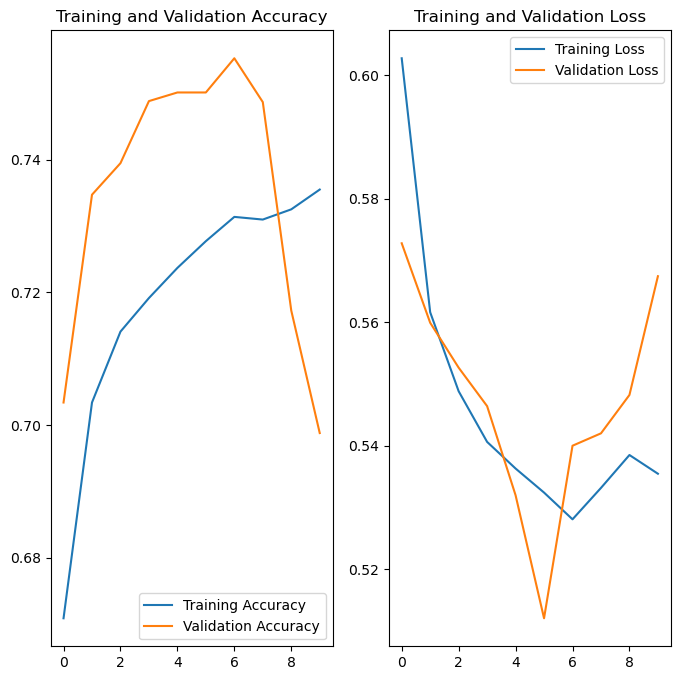

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()